In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

The network consists of a single layer of 180 neurons that receive activation from both exogenous inputs and lateral connections.

### Input activation
#### equation (7)

On simulated trial *n*, the mean input activation to neuron *i* is a function of the difference between the target location *$\theta(n)$* and the preferred direction of the neuron *$\theta_i^*$*


target: *$I_i(n)$*, mean activation of unit i  
baseline: *$I_0$*, baseline input rate  
gain: *$\gamma$*, input gain  
target: *$\theta(n)$*,  target location  
preference: *$\theta_i^*$*, prefered direction of unit i  
spread: *$\omega_I$*, spread of input activation (full-width-half-magnitude / FWHM)  


In [2]:
# define input activation function

def input_activation(target, preference, baseline=0, gain=1, spread=12):
    activation = baseline + gain * np.exp(-np.log(2) * ((target-preference) / (spread/2))**2)    
    return activation



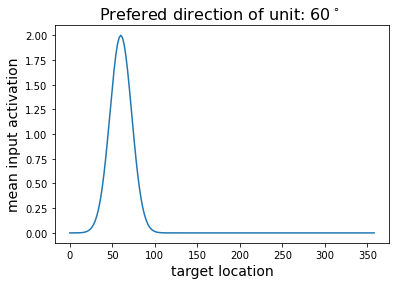

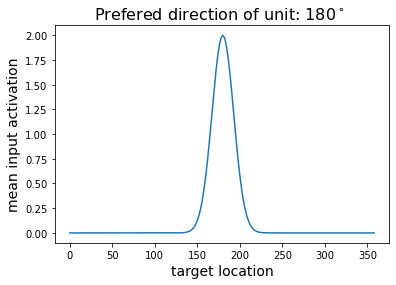

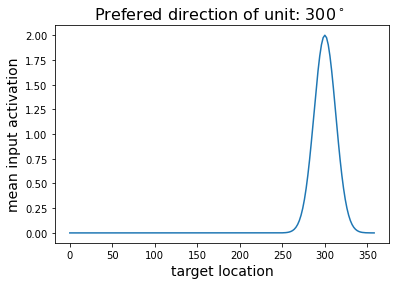

In [3]:
# Plot activation profile for and example unit

def plot_input_activation_profile(prefered_direction, baseline=0, gain=1, spread=12):
    # calculate activation for all orientations between 0 and 360 degrees
    target = np.arange(0,360,2)
    activation = np.zeros(len(target))

    for ii in range(len(target)):
        activation[ii] = input_activation(target[ii], prefered_direction, 
                                          baseline=baseline, gain=gain, spread=spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(target, activation)
    plt.xlabel('target location', fontsize=14)
    plt.ylabel('mean input activation', fontsize=14)
    plt.title('Prefered direction of unit: %d$^\circ$ ' %prefered_direction, fontsize=16)
    
for pref in[60, 180, 300]:
    plot_input_activation_profile(pref, baseline=0, gain=2, spread=30)

### Trial iteration
#### equation (8)

Add Gaussian noise to input activation

In [4]:
def calc_covariance(activation, fano=2, psi=5.45, rho=0.1):
    # calc variance
    variance =  fano * activation
    sigma = np.sqrt(variance)
    
    # calc covariance as product of sigma_i and sigma_j (without fall-off w/ distance)
    sigma_i_sigma_j = np.outer(sigma, sigma)
    
    # calc fall-off with distance between preffered angles 
    covariance = np.zeros_like(sigma_i_sigma_j)
    for i, pref_i in enumerate(pref_dirs):
        for j, pref_j in enumerate(pref_dirs):
            if i == j:
                covariance[i,j] = variance[i]
            else:
                covariance[i,j] =  sigma_i_sigma_j[i,j] * rho * 0.5**(2*abs(pref_i-pref_j)/psi)
    
    
    return covariance
    

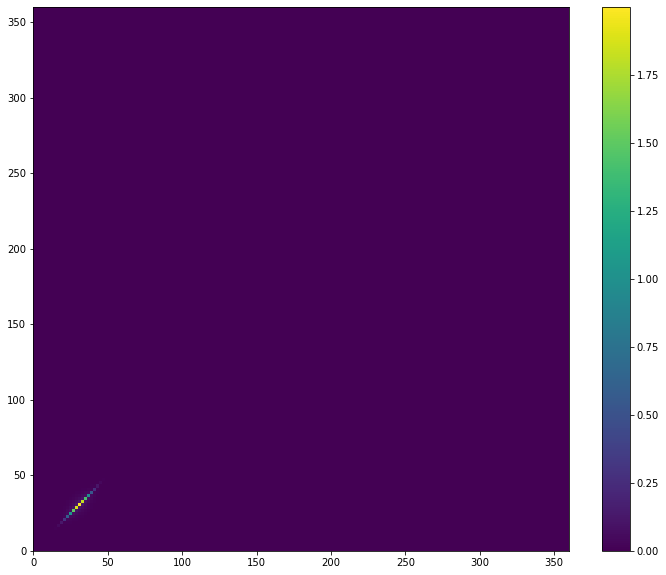

In [5]:
target = 30

pref_dirs = np.linspace(0,360,180)
activation = np.zeros(len(pref_dirs))

for ii, pref_i in enumerate(pref_dirs):
    activation[ii] = input_activation(target, pref_i) 
    
covariance = calc_covariance(activation, fano=2, psi=5.45, rho=0.1)

# plot 
plt.figure(figsize=[12,10])
plt.pcolormesh(pref_dirs, pref_dirs, covariance)
plt.colorbar()
plt.show()

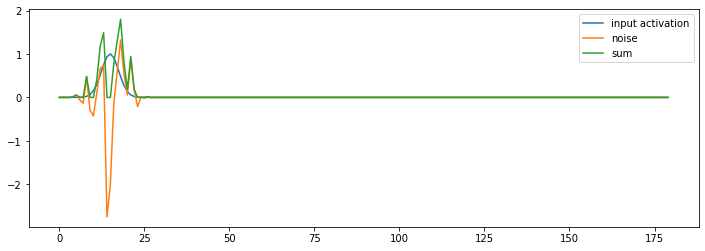

In [6]:
# calculate noise
noise = multivariate_normal.rvs(np.zeros_like(pref_dirs), covariance, size=1)

# add noise to input activation
activation_n_noise = activation + noise

# take positive part
activation_n_noise[activation_n_noise<0] = 0

# plot activation
plt.figure(figsize=[12,4])
plt.plot(activation,label='input activation')
plt.plot(noise,label='noise')
plt.plot(activation_n_noise,label='sum')
plt.legend()


In [7]:
def add_noise(activation):
    covariance = calc_covariance(activation)
    
    # calculate noise
    noise = multivariate_normal.rvs(np.zeros_like(pref_dirs), covariance, size=1)

    # add noise to input activation
    activation_n_noise = activation + noise

    # take positive part
    activation_n_noise[activation_n_noise<0] = 0
    
    return activation_n_noise


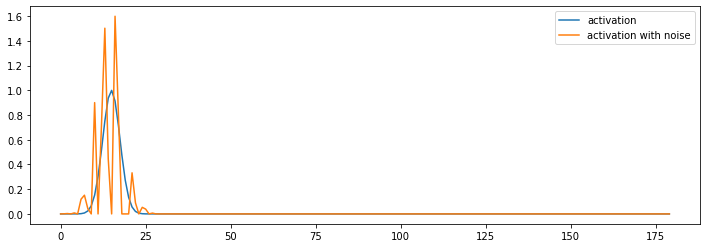

In [8]:
# test noise function

temp = add_noise(activation)

# plot activation
plt.figure(figsize=[12,4])
plt.plot(activation,label='activation')
plt.plot(temp,label='activation with noise')
plt.legend()

### Lateral connection strength
#### equation (9)

The initial connection strength between a pair of units is determined by the distance between the units’ preferred directions in the circular space (preferred directions were evenly spaced at delta = 2 degrees)  

###### variables
W_ij: *$W_{ij}$* lateral connection strength (unit j to unit i)  
pref_i: *$\theta_i^*$*, prefered direction of unit i  
pref_j: *$\theta_j^*$*, prefered direction of unit j  
spread: *$\omega_L$*, full-width-half-magnitude (FWHM)

In [9]:
# define lateral connection strength function

def connection_strength(pref_i, pref_j, spread=30):
    W_ij = np.exp(-np.log(2) * ((pref_i-pref_j) / (spread/2))**2)    
    return W_ij

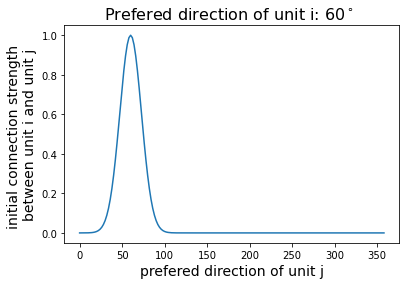

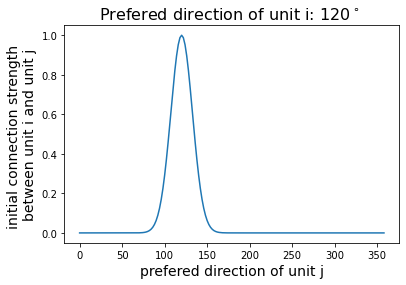

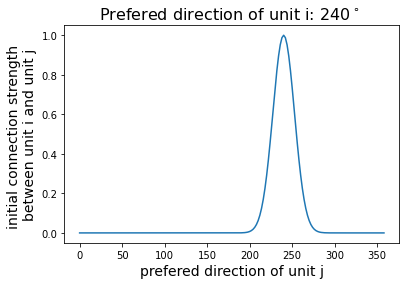

In [10]:
# Plot activation profile for and example unit

def plot_connection_strength_profile(pref_i, spread=12):
    # calculate connection
    pref_j = np.arange(0,360,2)
    W_ij = np.zeros(len(pref_j))

    for j in range(len(pref_j)):
        W_ij[j] = connection_strength(pref_i, pref_j[j], spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(pref_j, W_ij)
    plt.xlabel('prefered direction of unit j', fontsize=14)
    plt.ylabel('initial connection strength \nbetween unit i and unit j', fontsize=14)
    plt.title('Prefered direction of unit i: %d$^\circ$ ' %pref_i, fontsize=16)
    
for pref_i in[60, 120, 240]:
    plot_connection_strength_profile(pref_i, spread=30)

In [11]:
def calc_initial_weights(pref_dirs, spread=30):

    # calc weight between units
    initial_weights = np.zeros([len(pref_dirs), len(pref_dirs)])
    for i, pref_i in enumerate(pref_dirs):
        for j, pref_j in enumerate(pref_dirs):
            initial_weights[i,j] = connection_strength(i, j, spread=spread)
            
    return initial_weights
           

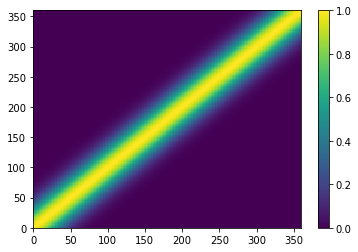

In [12]:
# create and plot an example initial weight matrix

# calc initial weights
pref_dirs = np.linspace(0,360,180)
initial_weights = calc_initial_weights(pref_dirs, spread=30)

# plot weights
plt.pcolormesh(pref_dirs, pref_dirs, initial_weights)
plt.colorbar()

### Total Activation
#### equation (10)

On each iteration *t*, the total activation for unit *i* was then computed as the sum of the input and recurrent activations

In [13]:
def total_activation(firing_rate, weights, theta, pref_dirs, 
                     baseline=0, gain=1E3, spread=12):    
    # calc input activation
    activation_raw = input_activation(theta, pref_dirs, baseline=baseline, gain=gain, spread=spread)
    activation = add_noise(activation_raw)
    
    # calc recurrent activation
    recurrent = np.dot(weights, firing_rate)
    
    # calc total activation
    total_activation = activation + recurrent
    
    return total_activation


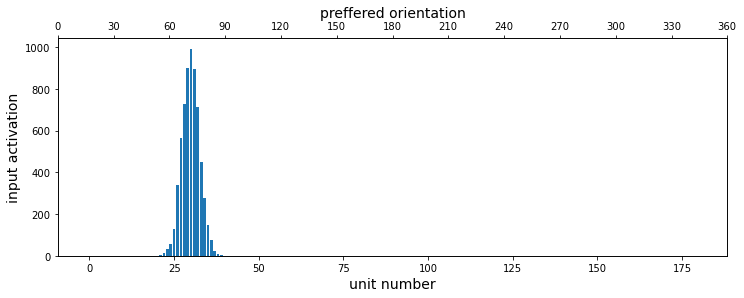

In [14]:
# calc input activation example

# define input angle
THETA = 60 
N_UNITS = 180

# define 180 units, assign preference
pref_dirs = np.arange(0,360,360/N_UNITS) # prefered angle
X = np.zeros_like(pref_dirs) # firing rates

# calculate input activation of each unit
U = lambda preference: total_activation(X, initial_weights, THETA, pref_dirs)
act = U(pref_dirs)

# plot input activation of each unit
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.bar(np.arange(180), act)

ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)

xx = np.linspace(0,360,13)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preffered orientation', fontsize=14)
plt.show()

### Firing Rates
#### equation (11)

Total activation was normalized on each iteration to obtain the new firing rates

In [15]:
def norm_activation(activation, a=0.002, b=0.001):
    norm = np.zeros_like(activation)
    for ii, act in enumerate(activation):
        norm[ii] = act**2 / (a + b * np.sum(activation**2))
        
    return norm  

### Hebbian learning rule
#### equation (12) 

After each iteration, the recurrent weights Wij were updated using a
normalized Hebbian learning rule [(Oja, 1982)](https://link.springer.com/article/10.1007/BF00275687)

beta: *$\beta$* learning rate  
alpha: *$\alpha$* normalization parameter  
weights: *$W_{ij}$*, synaptic weights  
updated_weights: *$W_{ij, t+1}$*; updated weight  
X: firing rates

In [16]:
def update_weights(weights, X, beta=1E-5, alpha=1E-3):
    # calc new weights
    updated_weights = weights + beta*(np.outer(X, X) - (alpha*(weights*(X**2)).T))
    
    return updated_weights

Text(0.5, 1.0, 'updated weights')

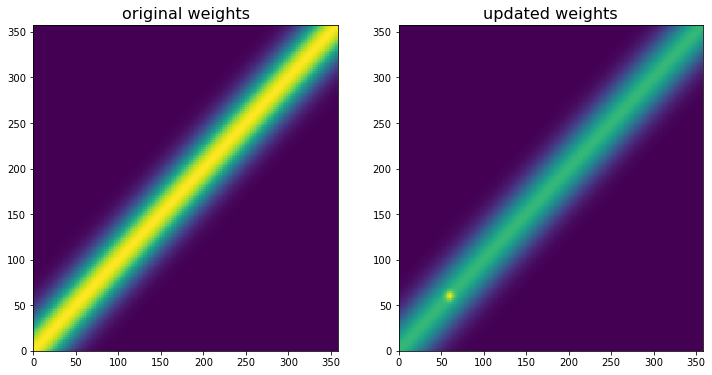

In [17]:
updated_weights = update_weights(initial_weights, norm_activation(act), 
                                 beta=1E-5, alpha=1E-3)

# plot weights
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].pcolormesh(pref_dirs, pref_dirs, initial_weights)
ax[0].set_title('original weights', fontsize=16)

# plot weights
ax[1].pcolormesh(pref_dirs, pref_dirs, updated_weights)
ax[1].set_title('updated weights', fontsize=16)

### Estimated Movement Vector
#### equation (13) 

[Georgopoulos, 1988](https://www.jneurosci.org/content/8/8/2928)


In [18]:
def decode_output(firing_rates, pref_dirs):
    # convert to radians, decode output
    x_comp = np.sum(firing_rates*np.cos(np.radians(pref_dirs)))
    y_comp = np.sum(firing_rates*np.sin(np.radians(pref_dirs)))
    output = np.degrees(np.arctan2(y_comp, x_comp))
        
    return output


## Build Adaptive Baysian model

In [19]:
# begin by building model with fixed weights

def calc_firing_rates(firing_rates, theta, pref_dirs, weights, 
                     baseline=0, gain=1E3, spread=12):
    
    # calc total activation
    activation = total_activation(firing_rates, weights, theta, pref_dirs, 
                                  baseline=baseline, gain=gain, spread=spread)

    # normalize activation
    firing_rates = norm_activation(activation)
    
    return firing_rates
       
def run_trial(initial_weights, pref_dirs, theta, n_iterations=5,
              baseline=0, gain=1E3, spread=30,
              beta=1E-5, alpha=1E-3):
    
    # initial conditions
    firing_rates = np.zeros([n_iterations+1, len(pref_dirs)])
    weights = np.zeros([n_iterations+1, initial_weights.shape[0], initial_weights.shape[1]])
    weights[0] = initial_weights

    # run 5 iterations
    for ii in np.arange(1,n_iterations+1):
        firing_rates[ii] = calc_firing_rates(firing_rates[ii-1], theta, pref_dirs, weights[ii-1],
                                            baseline=baseline, gain=gain, spread=spread)
        weights[ii] = update_weights(weights[ii-1], firing_rates[ii-1], beta=beta, alpha=alpha)
        
    # decode output
    output = decode_output(firing_rates[5], pref_dirs)
    
    return output, firing_rates, weights
   

In [20]:
# run an example trial

# define parameters
THETA = 45 # input angle
N_UNITS = 180 # number of units in network

# define units with evenly spaced preferred directions
pref_dirs = np.arange(-180,180,360/N_UNITS)

# define initial weight matrix
initial_weights = calc_initial_weights(pref_dirs, spread=30)

# run trial
output, firing_rates, weights = run_trial(initial_weights, pref_dirs, THETA,
                                          baseline=0, gain=1E3, spread=30,
                                          beta=1E-5, alpha=1E-3)

# print results
print('Target location: %d\N{DEGREE SIGN}' %THETA)
print('Decoded movement angle: %0.2f\N{DEGREE SIGN}' %output)


Target location: 45°
Decoded movement angle: 45.10°


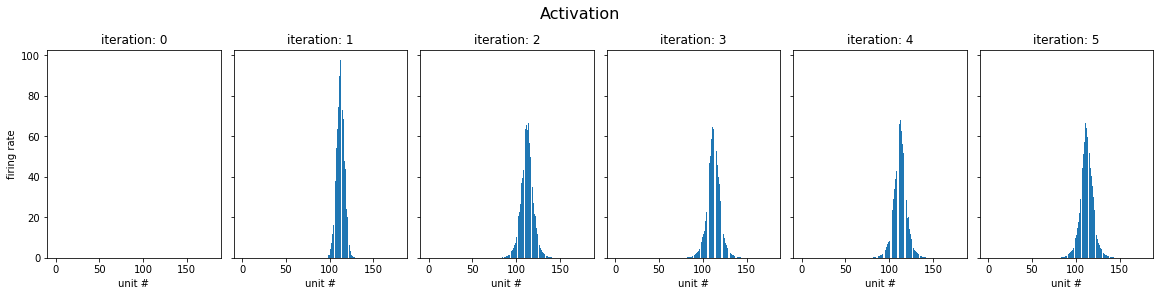

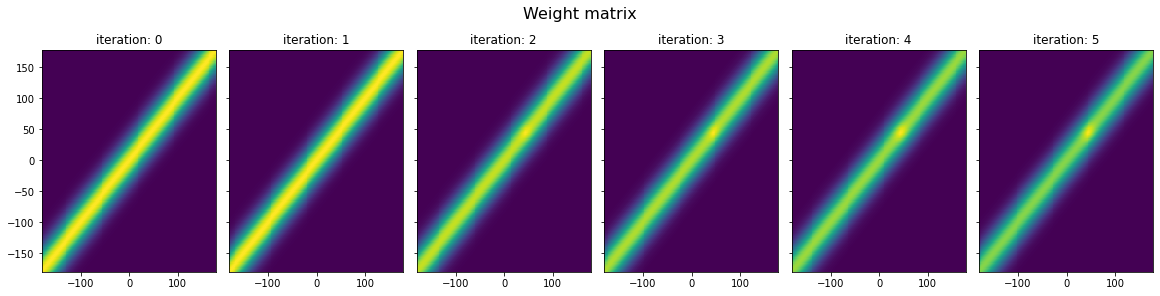

In [21]:
def plot_trial(firing_rates, weights, pref_dirs):
    # plot evolution of firing rates
    fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
    fig.suptitle('Activation', fontsize=16)
    ax[0].set(ylabel='firing rate')
    for i in range(firing_rates.shape[0]):
        # plot
        ax[i].bar(np.arange(N_UNITS), firing_rates[i])

        #label
        ax[i].set(xlabel='unit #')
        ax[i].set(title='iteration: %d' %i)
    plt.show()

    # plot evolution of weights
    fig, ax = plt.subplots(1,6, figsize=[16,4], sharey='all', constrained_layout=True)
    fig.suptitle('Weight matrix', fontsize=16)
    for i in range(firing_rates.shape[0]):
        ax[i].pcolormesh(pref_dirs, pref_dirs, weights[i])
        ax[i].set(title='iteration: %d' %i)
    plt.show()
    
plot_trial(firing_rates, weights, pref_dirs)

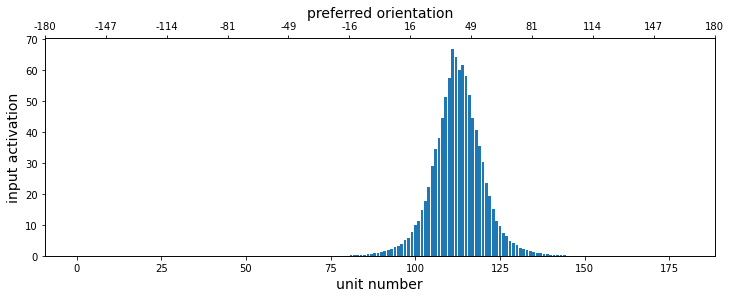

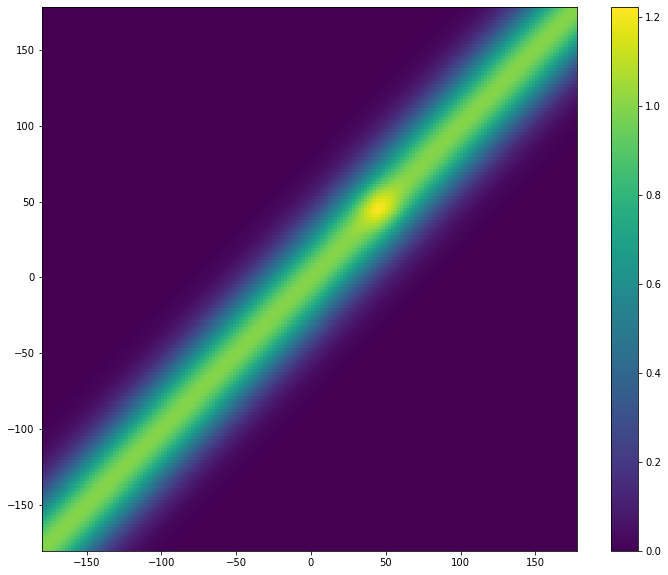

In [22]:
# plot final firing rates and weights on final interation of trial

# plot firing rates
# create figure
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
# plot data
ax1.bar(np.arange(N_UNITS), firing_rates[5])
# label plot
ax1.set_xlabel('unit number', fontsize=14)
ax1.set_ylabel('input activation', fontsize=14)
# add second x label
xx = np.linspace(pref_dirs[0],-pref_dirs[0], 12)
ax2.set_xticks(xx)
ax2.set_xticklabels([str(int(x)) for x in xx] )
ax2.set_xlabel('preferred orientation', fontsize=14)

# plot final weights
plt.figure(figsize=[12,10])
plt.pcolormesh(pref_dirs, pref_dirs, weights[5])
plt.colorbar()
plt.show()

## Test it!

#### Let's run some consecutive trials

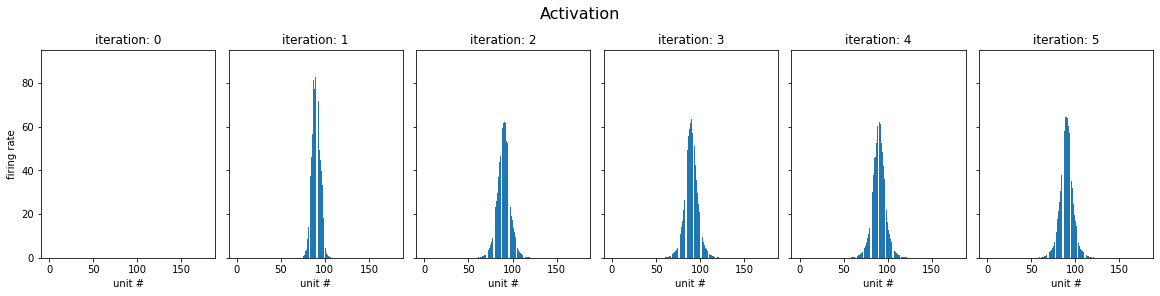

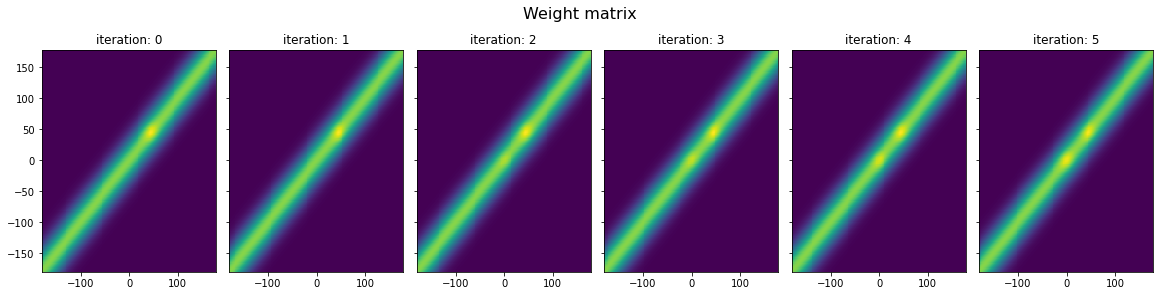

In [23]:
# run an example second trial

THETA = 0

# run trial 2
output, firing_rates_2, weights_2 = run_trial(weights[5], pref_dirs, THETA)

# plot
plot_trial(firing_rates_2, weights_2, pref_dirs)

#### create target distributions for diferent contexts

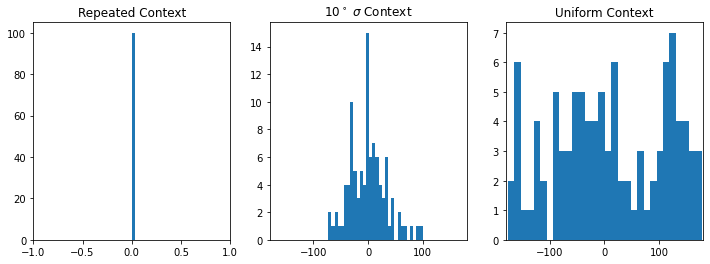

In [24]:
# parameteres
THETA = 0 # target angle for repeated context, and center of 10 degree context 
STD = 30 # standard deviation for 10 degree context 
N = 100 # number of trials

# generate distributions
distr_repeated = np.ones(N) * THETA
distr_10deg = np.random.normal(THETA, STD, N)
distr_uniform = np.random.rand(N) * 360 - 180

# plot 
n_bins = 30
titles = ['Repeated Context', '10$^\circ$ $\sigma$ Context', 'Uniform Context']
fig, ax = plt.subplots(1,3, figsize=[12,4])
ax[0].hist(distr_repeated, n_bins)
ax[1].hist(distr_10deg, n_bins)
ax[2].hist(distr_uniform, n_bins)

# set titles and axes limits
for ii, axes in enumerate(ax):
    axes.set(title=titles[ii], xlim=[-180,180])

# the repeated context distributin is not visible with mathed xlims
ax[0].set_xlim([-1,1])
    
plt.show()

#### run 100 trials with 10$^\circ$ context, then test

In [25]:
# run 100 trials

# define parameters
N_UNITS = 180 # number of units in network

# define units with evenly spaced preferred directions
pref_dirs = np.arange(-180,180,360/N_UNITS)

# define initial weight matrix
initial_weights = calc_initial_weights(pref_dirs, spread=30)

# create empty vars to populate
output = np.zeros(N)
firing_rates = np.zeros([N, len(pref_dirs)])
weights = np.zeros([N, initial_weights.shape[0], initial_weights.shape[1]])

# run trials
for ii, target in enumerate(distr_10deg):
    # set weights
    if ii == 0 :
        W = initial_weights
    else:
        W = weights[ii-1]
    
    # run trial
    output[ii], _, weights_all = run_trial(W, pref_dirs, target,
                                           baseline=0, gain=1E3, spread=30,
                                           beta=1E-5, alpha=1E-3)
    weights[ii] = weights_all[5]



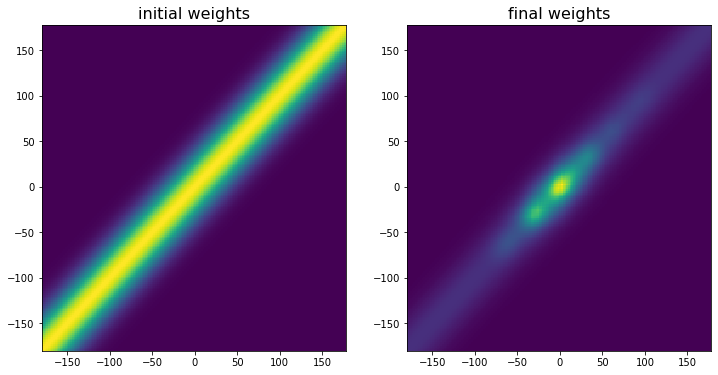

In [26]:
#plot final weight matrix

# plot weights
fig, ax = plt.subplots(1,2, figsize=[12,6])
ax[0].pcolormesh(pref_dirs, pref_dirs, initial_weights)
ax[0].set_title('initial weights', fontsize=16)

# plot weights
ax[1].pcolormesh(pref_dirs, pref_dirs, weights[N-1])
ax[1].set_title('final weights', fontsize=16)
plt.show()

#### test all 3 contexts

In [27]:
def test_context(target_distr):
    # define units with evenly spaced preferred directions
    pref_dirs = np.arange(-180,180,360/N_UNITS)

    # define initial weight matrix
    initial_weights = calc_initial_weights(pref_dirs, spread=30)
    
    # create empty vars to populate
    n_targets = len(target_distr)
    output = np.zeros(n_targets)
    firing_rates = np.zeros([n_targets, len(pref_dirs)])
    weights = np.zeros([n_targets, initial_weights.shape[0], initial_weights.shape[1]])

    # run trials
    for ii, target in enumerate(target_distr):
        # set weights
        if ii == 0 :
            W = initial_weights
        else:
            W = weights[ii-1]

        # run trial
        output[ii], _, weights_all = run_trial(W, pref_dirs, target,
                                               baseline=0, gain=1E3, spread=30,
                                               beta=1E-6, alpha=1E-3)
        weights[ii] = weights_all[5]
        
    final_weights = weights[n_targets-1]

    return final_weights
    

In [ ]:
# test contexts and plot final weight matrix

final_weights = []
fig, ax = plt.subplots(1,3,figsize=[12,4], constrained_layout=True)
plt.suptitle('Final weight matrix', fontsize=16)
for ii, target_distr in enumerate([distr_repeated, distr_10deg, distr_uniform]):
    final_weights.append(test_context(target_distr))
                         
    # plot final weights
    ax[ii].pcolormesh(pref_dirs, pref_dirs, final_weights[ii])
    ax[ii].set_title(titles[ii])
plt.show()

#### now probe the 3 resulting wight matrices

In [ ]:
# run an example trial

# define parameters
THETA = -135 # input angle
N_UNITS = 180 # number of units in network

# define units with evenly spaced preferred directions
pref_dirs = np.arange(-180,180,360/N_UNITS)

# run trial
output = np.zeros(len(final_weights))
for ii, W in enumerate(final_weights):
    output[ii], _, _= run_trial(W, pref_dirs, THETA)

# print results
print('Target location: %d\N{DEGREE SIGN}' %THETA)
print('Decoded movement angle:')
contexts = ['repeated context','%d\N{DEGREE SIGN} context' %STD,'uniform context']
for ii, context in enumerate(contexts):
    print('      %s: %0.2f\N{DEGREE SIGN}' %(context, output[ii]))


In [ ]:
# run trial
output, firing_rates, weights = run_trial(final_weights[1], pref_dirs, THETA,
                                          baseline=0, gain=1E3, spread=30,
                                          beta=1E-5, alpha=1E-3)

# print results
print('Target location: %d\N{DEGREE SIGN}' %THETA)
print('Decoded movement angle: %0.2f\N{DEGREE SIGN}' %output)

plot_trial(firing_rates, weights, pref_dirs)

### test the effect of context variance on response error

In [ ]:
# parameteres
PROBE = 45 # target on probe trial
THETA = 30 # center of target distribution
STD = [0, 5, 10, 25, 50] # standard deviation for 10 degree context 
N = 100 # number of trials
pref_dirs = np.arange(-180,180,360/N_UNITS)

output = np.zeros_like(STD)
for ii, std in enumerate(STD):
    # generate distribution
    target_distr = np.random.normal(THETA, std, N)
    
    # test context
    final_weights = test_context(target_distr)

    # probe trial
    output[ii], _, _= run_trial(final_weights, pref_dirs, PROBE)
        
output

In [ ]:
# calc error between reach and probe for each distr
error = np.abs(output - PROBE)

plt.figure()
plt.scatter(STD, error)
plt.plot(STD, error)
plt.xlabel('standard deviation of target distribution', fontsize=14)
plt.ylabel('error on probe trial', fontsize=14)
plt.title('context-dependent bias', fontsize=16)
plt.show()